# **A/B-тест эффективности обновленного экрана предложения покупки freemium-приложения**

**Ход работы**:
1. Изучение и аудит данных
2. Очищение и агрегация данных
3. Анализ распределения данных
4. Выбор метода исследования
5. Статистический анализ и интерпретация результатов

## Изучение и аудит данных

> На предварительном этапе знакомимся с данными и проверяем на наличие пропусков, дубликатов, соответствие типам данных.

Подключаем Google Drive как файловую систему, импортируем необходимые библиотеки, загружаем наш исходный датасет в переменную df и оцениваем структуру датасета:

In [1]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/ab_test/AB_Test_Results.csv')
print('Пример данных:')
display(df.head())

print('\nМетаданные датасета:')
df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Пример данных:


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0



Метаданные датасета:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


Видим, что столбцы соответствуют типам данных: идентификаторы - целочисленные, имена выборок - строковые, выручки - вещественные. Пропусков в данных также нет - во всех стобцах все 10000 значений ненулевые.

Проверим данные на валидность для A/B теста - в наших данных пользователь может присутствовать несколько раз (совершать несколько покупок), но только в рамках одной выборки, поэтому проверим, каждый ли пользователь принадлежит только к одной группе:

In [2]:
# сгруппируем датафрейм по пользователям
# и подсчитаем количество уникальных выборок в рамках каждого пользователя,
# результат выведем по убыванию - так пользователи с несколькими выборками будут видны в начале вывода

user_samples = df.groupby('USER_ID')['VARIANT_NAME'].nunique()
print(user_samples.sort_values(ascending=False).head())

USER_ID
10       2
10000    2
9978     2
9979     2
9982     2
Name: VARIANT_NAME, dtype: int64


Действительно, есть пользователи, состоящие сразу в двух группах. Посмотрим на них подробнее:

In [3]:
# сохраним ID таких пользователей
invalid_users = list(user_samples[user_samples > 1].index)
print(f'Количество недостоверных пользователей: {len(invalid_users):,} ({len(invalid_users)/len(user_samples):.1%})')

# отфильтруем датафрейм
print('\nПример недостоверных пользователей:')
display(df[df['USER_ID'].isin(invalid_users)].sort_values('USER_ID').head())

Количество недостоверных пользователей: 1,541 (24.4%)

Пример недостоверных пользователей:


,USER_ID,VARIANT_NAME,REVENUE
5377,3,control,0.0
4145,3,variant,0.0
7409,3,variant,0.0
5545,10,control,0.0
4612,10,variant,0.0


## Очищение и агрегация

> На этом этапе чистим данные и приводим их к виду, пригодному для дальнейших манипуляций

Наличие пользователей в обеих группах может быть ошибкой рандомизации или ошибкой логирования - в любом случае, это противоречит идее A/B теста, так как сегменты не должны влиять друг на друга. Таких пользователей нужно очистить.

In [4]:
df_cleaned = df[~df['USER_ID'].isin(invalid_users)]
print(f'Количество строк в очищенном датасете: {df_cleaned.shape[0]} ({df_cleaned.shape[0]/df.shape[0]:.1%})')

Количество строк в очищенном датасете: 6070 (60.7%)


Таким образом, нам пришлось избавиться от 39,3% данных.

Проверим, не изменились ли пропорции - выборки должны быть примерно равны по размеру:

In [5]:
# агрегируем данные выручки
df_final = df_cleaned.groupby(['USER_ID', 'VARIANT_NAME'])['REVENUE'].sum().reset_index()

print(df_final['VARIANT_NAME'].value_counts())

VARIANT_NAME
variant    2393
control    2390
Name: count, dtype: int64


Действительно, после очистки данных наши выборки остались примерно равными.

Таким образом, имеем на руках чистые данные, готовые к анализу.

## Анализ распределения данных

> На этапе анализа распределения нам нужно сделать вывод о характере распределения, проверить его на нормальность и отклонения от неё.

Для анализа распределения данных посмотрим на статистические характеристики наших выборок:

Статистические характеристики выручки контрольной группы:
count    2390.000000
mean        0.196887
std         4.172201
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       196.010000
Name: REVENUE, dtype: float64

Статистические характеристики выручки тестовой группы:
count    2393.000000
mean        0.074935
std         0.858207
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        23.040000
Name: REVENUE, dtype: float64


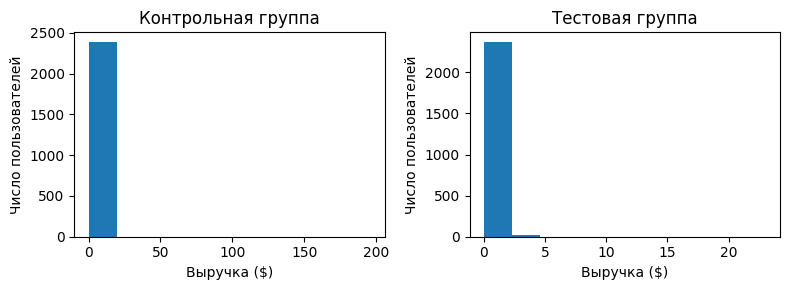

In [6]:
# сохраним выручки по группам в отдельных переменных
control_rev = df_final[df_final['VARIANT_NAME'] == 'control']['REVENUE']
variant_rev = df_final[df_final['VARIANT_NAME'] == 'variant']['REVENUE']

print('Статистические характеристики выручки контрольной группы:')
print(control_rev.describe())

print('\nСтатистические характеристики выручки тестовой группы:')
print(variant_rev.describe())

# импортируем библиотеку для построения графиков
import matplotlib.pyplot as plt

# строим гистограммы распределения выручки по группам
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].hist(control_rev)
axes[0].set_title('Контрольная группа')
axes[0].set_xlabel('Выручка ($)')
axes[0].set_ylabel('Число пользователей')

axes[1].hist(variant_rev)
axes[1].set_title('Тестовая группа')
axes[1].set_xlabel('Выручка ($)')
axes[1].set_ylabel('Число пользователей')

plt.tight_layout()
plt.show()

Видим, что распределение сильно скошено влево. Подавляющее количество пользователей не приносят выручку.

Посчитаем, какая вообще конверсия в покупку:

In [7]:
# создаем бинарный столбец для обозначения платящих пользователей,
# среднее значение этого столбца и будет значением конверсии

df_final['is_payer'] = (df_final['REVENUE'] > 0).astype(int)
conversion = df_final.groupby('VARIANT_NAME')['is_payer'].mean()
display(conversion)

,is_payer
VARIANT_NAME,
control,0.022594
variant,0.017551


Конверсия довольно низкая, впрочем, соответствующая типовым конверсиям freemium-приложений.

Тогда посмотрим на распределение выручки платящих пользователей:

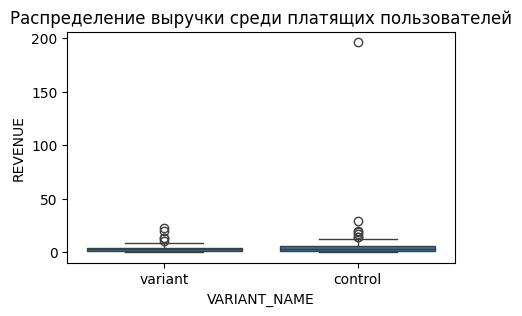

In [8]:
import seaborn as sns

# фильтруем только платящих
payers = df_final[df_final['is_payer'] == 1]

# boxplot только по ним
plt.figure(figsize=(5, 3))
sns.boxplot(data=payers, x='VARIANT_NAME', y='REVENUE')
plt.title('Распределение выручки среди платящих пользователей')
plt.show()

Картина не самая красивая из-за выброса в контрольной группе, отфильтруем его

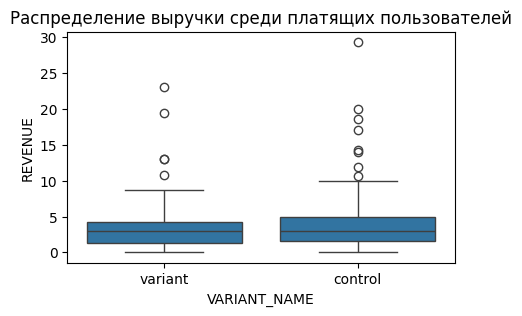

In [9]:
plt.figure(figsize=(5, 3))
sns.boxplot(data=payers[payers['REVENUE'] < 50], x='VARIANT_NAME', y='REVENUE')
plt.title('Распределение выручки среди платящих пользователей')
plt.show()

Таким образом, распределение выручки имеет экстремальную асимметрию: ~98% пользователей не совершили покупок, остальные ~2% сгенерировали всю выручку, при этом распределение их чеков также далеко от нормального и содержит выбросы.

## Выбор метода исследования

Полученная нами структура данных делает прямое применение классических параметрических тестов (например, t-теста) некорректным, поскольку они предполагают нормальность или умеренное отклонение от нее.

**Поэтому мы проведем два независимых теста:**

1. **Анализ конверсии в покупку**

При низкой базовой конверсии используем тест Фишера - наиболее консервативный и надежный метод для сравнения пропорций в условиях редких событий. В отличие от z-теста, он не опирается на нормальное приближение и дает точное p-value даже при малых частотах.

2. **Анализ размера покупки среди платящих**

Распределение чеков характеризуется сильной положительной асимметрией, наличием экстремальных значений и малым объёмом выборки. В таких условиях тест Манна-Уитни (непараметрический ранговый критерий) является оптимальным выбором: он не требует предположений о форме распределения и устойчив к выбросам. В качестве меры центральной тенденции используем медиану, а не среднее значение, поскольку она лучше отражает «типичный» чек в скошенном распределении.


## Статистический анализ и интерпретация результатов

> Приступаем непосредственно к анализу - проводим 2 независимых теста, как решили выше

### Тест 1. Анализ конверсии в покупку на основе точного теста Фишера

In [10]:
# импортируем функцию для проведения теста Фишера
from scipy.stats import fisher_exact

# считаем количество платящих и неплатящих по группам
conversion_table = df_final.groupby('VARIANT_NAME')['is_payer'].value_counts().unstack()

# убедимся, что столбцы в порядке: сначала 0 (не платил), потом 1 (платил)
conversion_table = conversion_table.reindex(columns=[0, 1])

# преобразуем датафрейм в обычный двумерный массив NumPy - таблицу сопряженности
contingency_table = conversion_table.values

# Проводим точный тест Фишера
odds_ratio, p_value_fisher = fisher_exact(contingency_table, alternative='two-sided')

print('Таблица сопряжённости (не платил / платил):')
print(conversion_table)
print(f'\nТочный тест Фишера:')
print(f'  p-value = {p_value_fisher:.4f}')
print(f'  Odds ratio = {odds_ratio:.3f}')

Таблица сопряжённости (не платил / платил):
is_payer         0   1
VARIANT_NAME          
control       2336  54
variant       2351  42

Точный тест Фишера:
  p-value = 0.2180
  Odds ratio = 0.773


**Интерпретация результатов:**

В ходе теста сравнивались 2 конверсии в платящих пользователей:
- в контрольной группе - 2.26% (54 пользователя из 2 390)
- в тестовой группе - 1.75% (42 пользователя из 2 393)

Результаты точного теста Фишера показали:
- **p-value = 0.218**  
- **Odds Ratio = 0.77**

Поскольку p-value превышает стандартный порог значимости α = 0.05, мы **не можем отклонить нулевую гипотезу**. Это означает, что наблюдаемое снижение конверсии в тестовой группе (на 0.51 процентного пункта, или ~23% относительно) **статистически не подтверждено** и может быть случайно.

Отношение шансов (Odds Ratio = 0.77) указывает на то, что **шансы совершить покупку в тестовой группе ниже**, чем в контрольной, однако из-за ограниченного числа платящих пользователей (~50 на группу) тест не обладает достаточной мощностью для надёжного обнаружения эффекта такого масштаба.

### Тест 2. Анализ размера покупки среди платящих

In [11]:
# импортируем функцию для проведения теста Манна-Уитни
from scipy.stats import mannwhitneyu

# фильтруем выручку только платящих пользователей
control_rev_paying = control_rev[control_rev > 0]
variant_rev_paying = variant_rev[variant_rev > 0]

# проводим тест Манна-Уитни
stat, p_value_mwu = mannwhitneyu(
    variant_rev_paying,
    control_rev_paying,
    alternative='two-sided'
    )

print('\nМетрики среди платящих:')
print(f'  Control: медиана = {control_rev_paying.median():.2f}, n = {len(control_rev_paying)}')
print(f'  Variant: медиана = {variant_rev_paying.median():.2f}, n = {len(variant_rev_paying)}')

print(f'\nТест Манна-Уитни:')
print(f'  p-value = {p_value_mwu:.4f}')
print(f'  U-статистика = {stat:.1f}')


Метрики среди платящих:
  Control: медиана = 3.12, n = 54
  Variant: медиана = 2.97, n = 42

Тест Манна-Уитни:
  p-value = 0.4402
  U-статистика = 1029.0


**Интерпретация результатов:**

В ходе теста сравнивались типичные (медианные) чеки платящих пользователей:
- в контрольной группе - \$3.12 (n = 54)
- в тестовой группе - \$2.97 (n = 42)

Результаты теста:
- **p-value = 0.4402**

Поскольку p-value значительно превышает порог значимости α = 0.05, мы **не можем отклонить нулевую гипотезу** о равенстве распределений размера покупки в двух группах. Это означает, что наблюдаемое различие в медианах \$0.15 (около 5% относительно) **статистически не подтверждено** и, скорее всего, обусловлено случайностью.

## Общие выводы:

Создадим автоматическую сводную таблицу для предоставления отчетности по a/b тесту:

In [12]:
summary_data = {
    'Метрика': ['Размер группы', 'Конверсия в покупку', 'Медианный чек платящих'],
    'Контроль (A)': [
        f'{len(control_rev):,}',
        f'{conversion.loc["control"]:.2%} ({int(conversion_table.loc["control", 1])})',
        f'{control_rev_paying.median():.2f}$'
    ],
    'Тест (B)': [
        f'{len(variant_rev):,}',
        f'{conversion.loc["variant"]:.2%} ({int(conversion_table.loc["variant", 1])})',
        f'{variant_rev_paying.median():.2f}$'
    ],
    'Разница (B - A)': [
        f'+{len(variant_rev) - len(control_rev)}',
        f'{conversion.loc["variant"] - conversion.loc["control"]:+.3f} п.п.',
        f'{variant_rev_paying.median() - control_rev_paying.median():+.2f}$'
    ],
    'p-value': ['—', f'{p_value_fisher:.3f}', f'{p_value_mwu:.3f}'],
    'Значимость (α=0.05)': ['—', 'Нет' if p_value_fisher > 0.05 else 'Да', 'Нет' if p_value_mwu > 0.05 else 'Да']
}

summary_df = pd.DataFrame(summary_data)
print('Сводные результаты A/B теста:')
display(summary_df)

Сводные результаты A/B теста:


,Метрика,Контроль (A),Тест (B),Разница (B - A),p-value,Значимость (α=0.05)
0,Размер группы,"2,390","2,393",+3,—,—
1,Конверсия в покупку,2.26% (54),1.76% (42),-0.005 п.п.,0.218,Нет
2,Медианный чек платящих,3.12$,2.97$,-0.15$,0.440,Нет


**Вывод по анализу конверсий по результатам теста Фишера**: нет статистически значимых доказательств того, что новая версия продукта влияет на вероятность первой покупки. Наблюдаемое различие в конверсии не является основанием для принятия решения о внедрении или отклонении изменений.

**Вывод по анализу средних чеков по результатам теста Манна-Уитни**: новая версия продукта не оказывает значимого влияния на поведение уже склонных к покупке пользователей — ни в части типичного размера чека, ни в склонности к более крупным или мелким тратам.

---
**Общий вывод:**

Таким образом, обновленный экран предложения покупки не демонстрирует улучшения ключевых метрик монетизации. Наблюдаемые изменения могут быть объяснены случайной вариацией, особенно учитывая низкую базовую конверсию (\~2%), ограниченное число платящих пользователей (~50 на группу), и также выявленное на предварительном этапе аудита данных нарушение принципа уникальности участия пользователей.

**Рекомендации:**

Увеличить объем выборки, провести дополнительные итерации тестирования, а также обеспечить корректную рандомизацию на уровне пользователя.